# Data Preprocessing

In [1]:
import math
from typing import List
import requests
import re
import os
import bs4
from bs4 import BeautifulSoup
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

## Downloading: programmatically download the Yellow Taxi & High-Volume For-Hire Vehicle (HVFHV) trip data 

In [2]:
TAXI_URL: str = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

def get_taxi_html() -> str:
    response = requests.get(TAXI_URL)
    html = response.content
    return html

def find_taxi_parquet_links() -> List[str]:
    ### BEGIN SOLUTION
    html = get_taxi_html()
    soup = bs4.BeautifulSoup(html, "html.parser")
    HVFHV_a_tags = soup.find_all("a", attrs={"title": "High Volume For-Hire Vehicle Trip Records"})
    yellow_a_tags = soup.find_all("a", attrs={"title": "Yellow Taxi Trip Records"})
    all_a_tags = HVFHV_a_tags + yellow_a_tags
    return [a["href"] for a in all_a_tags]
    ### END SOLUTION

In [3]:
def filter_urls(urls, start_year, start_month, end_year, end_month):
    filtered_urls = []
    for url in urls:
        match = re.search(r'(\d{4})-(\d{2})', url)
        if match:
            year, month = int(match.group(1)), int(match.group(2))
            if (start_year < year < end_year) or \
               (year == start_year and month >= start_month) or \
               (year == end_year and month <= end_month):
                filtered_urls.append(url.strip())
    return filtered_urls

# Filtering URLs from January 2020 to August 2024
urls = find_taxi_parquet_links()
filtered_urls = filter_urls(urls, 2020, 1, 2024, 8)

# Display the result
urls = sorted(filtered_urls)
urls

['https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2020-01.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2020-02.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2020-03.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2020-04.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2020-05.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2020-06.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2020-07.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2020-08.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2020-09.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2020-10.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2020-11.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2020-12.parquet',
 'ht

In [4]:
urls = urls
# Directory to save the downloaded files
output_directory = "Dataset"

# Create the directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Function to download a file
def download_parquet_file(i, url, output_directory):
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an error for bad HTTP responses
        
        # Extract file name from the URL
        file_name = url.split("/")[-1]
        file_path = os.path.join(output_directory, file_name)
        
        # Save the file
        with open(file_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=1024):
                file.write(chunk)
        print(f"File {i} Downloaded: {file_name}")
    except requests.RequestException as e:
        print(f"File {i} Failed to download {url}. Error: {e}")

# Download all files
for i, url in enumerate(urls):
    download_parquet_file(i, url, output_directory)

KeyboardInterrupt: 

## Sampling

In [4]:
def cochran_sample_size(N, p=0.5, e=0.05, confidence=0.95):
    """
    Calculate Cochran's sample size for a finite population.
    
    Parameters:
    N (int): Population size
    p (float): Proportion of population (default=0.5 for max variability)
    e (float): Margin of error (default=0.05 for ±5%)
    confidence (float): Confidence level (default=0.95 for 95%)
    
    Returns:
    int: Sample size
    """
    # Z-score for the given confidence level
    Z = {
        0.90: 1.645,
        0.95: 1.96,
        0.99: 2.576
    }.get(confidence, 1.96)  # Default to 95% confidence if not specified
    
    # Step 1: Cochran's formula for infinite population
    n0 = (Z**2 * p * (1 - p)) / (e**2)
    
    # Step 2: Adjust for finite population
    n = n0 / (1 + (n0 - 1) / N)
    
    return math.ceil(n)

def stable_sample_size(monthly_populations, p=0.5, e=0.05, confidence=0.99, method='max'):
    """
    Calculate a stable sample size across multiple months.
    
    Parameters:
    monthly_populations (list): List of population sizes for each month
    p (float): Proportion of population (default=0.5 for max variability)
    e (float): Margin of error (default=0.05 for ±5%)
    confidence (float): Confidence level (default=0.95 for 95%)
    method (str): Aggregation method ('max', 'average', 'safety')
    
    Returns:
    int: Stable sample size
    """
    sample_sizes = [cochran_sample_size(N, p, e, confidence) for N in monthly_populations]
    print(monthly_populations)
    
    if method == 'max':
        return max(sample_sizes)
    elif method == 'average':
        return math.ceil(sum(sample_sizes) / len(sample_sizes))
    elif method == 'safety':
        return math.ceil(max(sample_sizes) * 1.1)  # Add a 10% safety margin
    else:
        raise ValueError("Invalid method. Choose from 'max', 'average', or 'safety'.")

## Yellow Taxi
yellow_file_folder = 'Dataset/yellow_tripdata/'
yellow_file_names = [f for f in os.listdir(yellow_file_folder) if os.path.isfile(os.path.join(yellow_file_folder, f))]

monthly_populations_yellow = []
for file in yellow_file_names:
    parquet_file = pq.ParquetFile(yellow_file_folder + file)
    monthly_populations_yellow.append(parquet_file.metadata.num_rows)
    
# Example monthly population sizes
stable_size_yellow = stable_sample_size(monthly_populations_yellow, method='average')
print(f"Yellow Taxi Stable sample size: {stable_size_yellow}")

## Uber
fhvhv_file_folder = 'Dataset/fhvhv_tripdata/'
fhvhv_file_names = [f for f in os.listdir(fhvhv_file_folder) if os.path.isfile(os.path.join(fhvhv_file_folder, f))]

monthly_populations_uber = []
for file in fhvhv_file_names:
    parquet_file = pq.ParquetFile(fhvhv_file_folder + file)
    monthly_populations_uber.append(parquet_file.metadata.num_rows)
    
# Example monthly population sizes
stable_size_uber = stable_sample_size(monthly_populations_uber, method='average')
print(f"Uber Stable sample size: {stable_size_uber}")


FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'Dataset/yellow_tripdata/'

## Cleaning & Filtering

In [6]:
shapefile_path = 'taxi_zones.shp'
zones_gdf = gpd.read_file(shapefile_path)
if zones_gdf.crs is None:
    zones_gdf.set_crs(epsg=2263, inplace=True)  # Example: NY State Plane (EPSG:2263)
zones_gdf = zones_gdf.to_crs(epsg=4326) # Reproject to WGS84 (Latitude/Longitude)

# Calculate centroids for each zone (polygon)
zones_gdf['centroid'] = zones_gdf.geometry.centroid
zones_gdf['latitude'] = zones_gdf['centroid'].y
zones_gdf['longitude'] = zones_gdf['centroid'].x

# Retain only relevant columns: location ID, latitude, and longitude
zones_df = zones_gdf[['LocationID', 'latitude', 'longitude']]

### Yellow Taxi Filtering and Sampling

In [5]:
output_directory_yellow = "Clean_Sampled_Dataset/Yellow/"
os.makedirs(output_directory_yellow, exist_ok=True)

In [ ]:
for i, file in enumerate(yellow_file_names[:]):
    trips_df = pd.read_parquet(yellow_file_folder + file)
    print('Current Processing:', i, file)

    # Merge trip data with zone centroids for pickups and dropoffs
    trips_with_pickup = trips_df.merge(
        zones_df,
        how='left',
        left_on='PULocationID',
        right_on='LocationID'
    ).rename(columns={'latitude': 'pickup_latitude', 'longitude': 'pickup_longitude'})

    trips_with_locations = trips_with_pickup.merge(
        zones_df,
        how='left',
        left_on='DOLocationID',
        right_on='LocationID',
        suffixes=('', '_dropoff')
    ).rename(columns={'latitude': 'dropoff_latitude', 'longitude': 'dropoff_longitude'})

    # Filter out trips with invalid location IDs
    valid_trips = trips_with_locations.dropna(subset=['pickup_latitude', 'dropoff_latitude'])

    # Delete records that start_pos or end_pos is out of range
    LAT_MIN, LAT_MAX = 40.560445, 40.908524
    LON_MIN, LON_MAX = -74.242330, -73.717047
    
    valid_trips = valid_trips[
        (valid_trips['pickup_latitude'].between(LAT_MIN, LAT_MAX)) &
        (valid_trips['pickup_longitude'].between(LON_MIN, LON_MAX)) &
        (valid_trips['dropoff_latitude'].between(LAT_MIN, LAT_MAX)) &
        (valid_trips['dropoff_longitude'].between(LON_MIN, LON_MAX))
    ]
    ## Delete original locationID columns
    valid_trips.drop(['PULocationID','DOLocationID','LocationID','LocationID_dropoff'],axis=1,inplace=True)
    
    valid_trips.columns = valid_trips.columns.str.lower()
    
    ## Delete records that trip_distance is missing or trip_distance <= 0, and convert datatype into Float
    valid_trips = valid_trips.dropna(subset=['trip_distance'])
    valid_trips = valid_trips[valid_trips['trip_distance']>0]
    valid_trips['trip_distance'] = valid_trips['trip_distance'].astype(float)
    
    ## Delete records that passenger_count is missing or passenger_count <= 0, and convert datatype into Integer
    valid_trips = valid_trips.dropna(subset=['passenger_count'])
    valid_trips = valid_trips[valid_trips['passenger_count']>0]
    valid_trips['passenger_count'] = valid_trips['passenger_count'].astype(int)
    
    ## Delete records that where Fare_amount, Total_amount, or Tolls_amount are negative.
    valid_trips = valid_trips[
        (valid_trips['fare_amount']>=0) &
        (valid_trips['total_amount']>=0) &
        (valid_trips['tolls_amount']>=0)
        ]
    
    ## Delete records that Payment_type not in the valid range (1-6), and convert datatype into Integer
    valid_trips['payment_type'] = valid_trips['payment_type'].astype(int)
    valid_trips = valid_trips[valid_trips['payment_type'].between(1,6)]
    
    ## Delete records that RateCodeID not in the valid range (1-6), and convert datatype into Integer
    valid_trips['ratecodeid'] = valid_trips['ratecodeid'].astype(int)
    valid_trips = valid_trips[valid_trips['ratecodeid'].between(1,6)]
    valid_trips = valid_trips.rename(columns={'ratecodeid':'RateCodeID',})
    
    ## Convert store_and_fwd_flag into 0 and 1
    valid_trips['store_and_fwd_flag'] = valid_trips['store_and_fwd_flag'].map({'Y':1,'N':0}).fillna(0)
    
    ## Convert airport_fee into Float
    valid_trips['airport_fee'] = pd.to_numeric(valid_trips['airport_fee'], errors='coerce').fillna(0)
    
    ## Rename: extra -> Miscellaneous_Extras, tpep_pickup_datetime → pickup_datetime, tpep_dropoff_datetime → dropoff_datetime
    valid_trips = valid_trips.rename(
        columns={'extra':'Miscellaneous_Extras','tpep_pickup_datetime':'pickup_datetime','tpep_dropoff_datetime':'dropoff_datetime'})
    
    ## Delete records that dropoff_datetime is earlier than pickup_datetime.
    valid_trips = valid_trips[valid_trips['dropoff_datetime'] >= valid_trips['pickup_datetime']]
    
    ## Sampling & Save to parquet file
    valid_trips = valid_trips.sample(n=stable_size_yellow, random_state=42).reset_index(drop=True)
    valid_trips.to_parquet(output_directory_yellow + file)


In [7]:
yellow_sampled_records = pd.DataFrame()
yellow_sampled_file_names = [f for f in os.listdir(output_directory_yellow) if os.path.isfile(os.path.join(output_directory_yellow, f))]

for file in yellow_sampled_file_names:
    sampled_df = pd.read_parquet(output_directory_yellow + file)
    yellow_sampled_records = pd.concat([yellow_sampled_records,sampled_df],axis=0)
    
output_directory_final = "Clean_Sampled_Dataset/Final/"
yellow_sampled_records.to_parquet(output_directory_final + 'Yellow_all.parquet')

### Uber Sampling & Filtering

In [6]:
output_directory_uber = "Clean_Sampled_Dataset/Uber/"
os.makedirs(output_directory_uber, exist_ok=True)

In [ ]:
for i, file in enumerate(fhvhv_file_names[:]):
    trips_df = pd.read_parquet(fhvhv_file_folder + file)
    print('Current Processing:', i, file)
    
    ## Retain records that are Uber rides
    trips_df = trips_df[trips_df['hvfhs_license_num'] == 'HV0003']

    # Merge trip data with zone centroids for pickups and dropoffs
    trips_with_pickup = trips_df.merge(
        zones_df,
        how='left',
        left_on='PULocationID',
        right_on='LocationID'
    ).rename(columns={'latitude': 'pickup_latitude', 'longitude': 'pickup_longitude'})

    trips_with_locations = trips_with_pickup.merge(
        zones_df,
        how='left',
        left_on='DOLocationID',
        right_on='LocationID',
        suffixes=('', '_dropoff')
    ).rename(columns={'latitude': 'dropoff_latitude', 'longitude': 'dropoff_longitude'})

    # Filter out trips with invalid location IDs
    valid_trips = trips_with_locations.dropna(subset=['pickup_latitude', 'dropoff_latitude'])

    # Delete records that start_pos or end_pos is out of range
    LAT_MIN, LAT_MAX = 40.560445, 40.908524
    LON_MIN, LON_MAX = -74.242330, -73.717047
    
    valid_trips = valid_trips[
        (valid_trips['pickup_latitude'].between(LAT_MIN, LAT_MAX)) &
        (valid_trips['pickup_longitude'].between(LON_MIN, LON_MAX)) &
        (valid_trips['dropoff_latitude'].between(LAT_MIN, LAT_MAX)) &
        (valid_trips['dropoff_longitude'].between(LON_MIN, LON_MAX))
    ]
    ## Delete original locationID columns
    valid_trips.drop(['PULocationID','DOLocationID','LocationID','LocationID_dropoff'],axis=1,inplace=True)
    
    valid_trips.columns = valid_trips.columns.str.lower()
    
    ## Delete records that trip_distance is missing or trip_distance <= 0, and convert datatype into Float
    valid_trips = valid_trips.dropna(subset=['trip_miles'])
    valid_trips = valid_trips[valid_trips['trip_miles']>0]
    valid_trips['trip_miles'] = valid_trips['trip_miles'].astype(float)
    
    ## Delete records that trip_time is missing or trip_distance <= 0, and convert datatype into Float
    valid_trips = valid_trips.dropna(subset=['trip_time'])
    valid_trips = valid_trips[valid_trips['trip_time']>0]
    valid_trips['trip_time'] = valid_trips['trip_time'].astype(float)
    
    ## Delete records that where base_passenger_fare, tolls, sales_tax, bcf, tips, congestion_surcharge or driver_pay are negative.
    valid_trips = valid_trips[
        (valid_trips['base_passenger_fare']>=0) &
        (valid_trips['tolls']>=0) &
        (valid_trips['sales_tax']>=0) &
        (valid_trips['bcf']>=0) &
        (valid_trips['tips']>=0) &
        (valid_trips['congestion_surcharge']>=0) &
        (valid_trips['driver_pay']>=0) 
        ]
    
    ## Convert shared_request_flag, shared_match_flag, access_a_ride_flag, wav_request_flag, wav_match_flag into 0 and 1
    valid_trips['shared_request_flag'] = valid_trips['shared_request_flag'].map({'Y':1,'N':0}).fillna(0)
    valid_trips['shared_match_flag'] = valid_trips['shared_match_flag'].map({'Y':1,'N':0}).fillna(0)
    valid_trips['access_a_ride_flag'] = valid_trips['access_a_ride_flag'].map({'Y':1,'N':0}).fillna(0)
    valid_trips['wav_request_flag'] = valid_trips['wav_request_flag'].map({'Y':1,'N':0}).fillna(0)
    valid_trips['wav_match_flag'] = valid_trips['wav_match_flag'].map({'Y':1,'N':0}).fillna(0)
    
    ## Delete records that dropoff_datetime is earlier than pickup_datetime.
    valid_trips = valid_trips[valid_trips['dropoff_datetime'] >= valid_trips['pickup_datetime']]
    
    ## Delete records that on_scene_datetime is earlier than request_datetime.
    valid_trips = valid_trips[valid_trips['on_scene_datetime'] >= valid_trips['request_datetime']]
    
    ## Rename: bcf -> Black_Car_Fund
    valid_trips = valid_trips.rename(
        columns={'bcf':'Black_Car_Fund',})
    
    ## Delete useless columns: dispatching_base_num, Hvfhs_license_num, originating_base_num
    valid_trips = valid_trips.drop(['hvfhs_license_num','dispatching_base_num','originating_base_num'], axis=1)
    
    ## Sampling & Save to parquet file
    valid_trips = valid_trips.sample(n=stable_size_uber, random_state=42).reset_index(drop=True)
    valid_trips.to_parquet(output_directory_uber + file)


In [9]:
uber_sampled_records = pd.DataFrame()
uber_sampled_file_names = [f for f in os.listdir(output_directory_uber) if os.path.isfile(os.path.join(output_directory_uber, f))]

for file in uber_sampled_file_names:
    sampled_df = pd.read_parquet(output_directory_uber + file)
    uber_sampled_records = pd.concat([uber_sampled_records,sampled_df],axis=0)
    
output_directory_final = "Clean_Sampled_Dataset/Final/"
uber_sampled_records.to_parquet(output_directory_final + 'Uber_all.parquet')

### Weather data preprocessing: Hourly

In [9]:
weather_data_file_folder = 'Dataset/weather_data/'
weather_data_files = ['2020_weather.csv','2021_weather.csv','2022_weather.csv','2023_weather.csv','2024_weather.csv']

weather_data_hourly_df = pd.DataFrame()
for file in weather_data_files:
    print("Current Processing:", file)
    weather_data = pd.read_csv(weather_data_file_folder + file)

    ## Split Date and Hour
    weather_data[['Date', 'Hour']] = weather_data['DATE'].str.split('T', expand=True)
    
    weather_data_hourly = weather_data[weather_data['Hour'] !='23:59:00']
    weather_data_hourly['Hour'] = weather_data_hourly['Hour'].str.split(':').str[0]
    weather_data_hourly = weather_data_hourly.groupby(['Date','Hour']).first().reset_index()

    original_columns = list(weather_data_hourly.columns)
    columns_to_drop = ['DATE','ELEVATION','STATION','NAME','LATITUDE','LONGITUDE','NormalsCoolingDegreeDay','NormalsHeatingDegreeDay','Sunrise', 'Sunset','WindEquipmentChangeDate'] \
    + ['AWND','CDSD','CLDD','DSNW','HDSD','HTDD','DYTS','DYHF',] \
    + ['HourlyPresentWeatherType','HourlySkyConditions','REM','HourlyWindDirection'] \
    + [col for col in original_columns if col.startswith('Daily')] \
    + [col for col in original_columns if col.startswith('Monthly')] \
    + [col for col in original_columns if col.startswith('Backup')] \
    + [col for col in original_columns if col.startswith('ShortDuration')]
    weather_data_hourly = weather_data_hourly.drop(columns_to_drop,axis=1)

    ## Transform data type & Fill missing values
    weather_data_hourly['Hour'] = weather_data_hourly['Hour'].astype(int)
    weather_data_hourly['HourlyAltimeterSetting'] = pd.to_numeric(weather_data_hourly['HourlyAltimeterSetting'], errors='coerce')
    weather_data_hourly['HourlyAltimeterSetting'] = weather_data_hourly['HourlyAltimeterSetting'].fillna(weather_data_hourly['HourlyAltimeterSetting'].mean())
    weather_data_hourly['HourlyDewPointTemperature'] = pd.to_numeric(weather_data_hourly['HourlyDewPointTemperature'], errors='coerce')
    weather_data_hourly['HourlyDewPointTemperature'] = weather_data_hourly['HourlyDewPointTemperature'].fillna(weather_data_hourly['HourlyDewPointTemperature'].mean())
    weather_data_hourly['HourlyDryBulbTemperature'] = pd.to_numeric(weather_data_hourly['HourlyDryBulbTemperature'], errors='coerce')
    weather_data_hourly['HourlyDryBulbTemperature'] = weather_data_hourly['HourlyDryBulbTemperature'].fillna(weather_data_hourly['HourlyDryBulbTemperature'].mean())
    weather_data_hourly['HourlySeaLevelPressure'] = pd.to_numeric(weather_data_hourly['HourlySeaLevelPressure'], errors='coerce')
    weather_data_hourly['HourlySeaLevelPressure'] = weather_data_hourly['HourlySeaLevelPressure'].fillna(weather_data_hourly['HourlySeaLevelPressure'].mean())
    weather_data_hourly['HourlyStationPressure'] = pd.to_numeric(weather_data_hourly['HourlyStationPressure'], errors='coerce')
    weather_data_hourly['HourlyStationPressure'] = weather_data_hourly['HourlyStationPressure'].fillna(weather_data_hourly['HourlyStationPressure'].mean())

    weather_data_hourly['HourlyVisibility'] = weather_data_hourly['HourlyVisibility'].str.extract(r'(\d+\.\d+)', expand=False)
    weather_data_hourly['HourlyVisibility'] = pd.to_numeric(weather_data_hourly['HourlyVisibility'], errors='coerce')
    weather_data_hourly['HourlyVisibility'] = weather_data_hourly['HourlyVisibility'].fillna(weather_data_hourly['HourlyVisibility'].mean())

    weather_data_hourly['HourlyPrecipitation'] = weather_data_hourly['HourlyPrecipitation'].replace('T', 0.0005)
    weather_data_hourly['HourlyPrecipitation'] = weather_data_hourly['HourlyPrecipitation'].replace(['M', ''], np.nan)
    weather_data_hourly['HourlyPrecipitation'] = weather_data_hourly['HourlyPrecipitation'].fillna(0)
    weather_data_hourly['HourlyPrecipitation'] = pd.to_numeric(weather_data_hourly['HourlyPrecipitation'], errors='coerce')
    weather_data_hourly['HourlyPrecipitation'] = weather_data_hourly['HourlyPrecipitation'].fillna(0)

    weather_data_hourly['HourlyPressureChange'] = pd.to_numeric(weather_data_hourly['HourlyPressureChange'], errors='coerce')
    weather_data_hourly['HourlyPressureChange'] = weather_data_hourly['HourlyPressureChange'].fillna(0)
    weather_data_hourly['HourlyPressureTendency'] = pd.to_numeric(weather_data_hourly['HourlyPressureTendency'], errors='coerce')
    weather_data_hourly['HourlyPressureTendency'] = weather_data_hourly['HourlyPressureTendency'].fillna(0)
    weather_data_hourly['HourlyRelativeHumidity'] = pd.to_numeric(weather_data_hourly['HourlyPrecipitation'], errors='coerce')
    weather_data_hourly['HourlyRelativeHumidity'] = weather_data_hourly['HourlyRelativeHumidity'].fillna(0)
    weather_data_hourly['HourlyWetBulbTemperature'] = pd.to_numeric(weather_data_hourly['HourlyWetBulbTemperature'], errors='coerce')
    weather_data_hourly['HourlyWetBulbTemperature'] = weather_data_hourly['HourlyWetBulbTemperature'].fillna(weather_data_hourly['HourlyWetBulbTemperature'].mean())
    weather_data_hourly['HourlyWindGustSpeed'] = weather_data_hourly['HourlyWindGustSpeed'].fillna(weather_data_hourly['HourlyWindGustSpeed'].mean())
    weather_data_hourly['HourlyWindSpeed'] = weather_data_hourly['HourlyWindSpeed'].fillna(weather_data_hourly['HourlyWindSpeed'].mean())

    weather_data_hourly_df = pd.concat([weather_data_hourly_df,weather_data_hourly],axis=0)
    
output_directory_final = "Clean_Sampled_Dataset/Final/"
weather_data_hourly_df.to_parquet(output_directory_final + 'Weather_hourly.parquet')

Current Processing: 2020_weather.csv
Current Processing: 2021_weather.csv
Current Processing: 2022_weather.csv
Current Processing: 2023_weather.csv
Current Processing: 2024_weather.csv


In [10]:
weather_data_hourly_df.head()

,Date,Hour,REPORT_TYPE,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindGustSpeed,HourlyWindSpeed
0,2020-01-01,0,FM-15,7,29.66,26.0,40.0,0.0,-0.01,3.0,0.0,29.64,29.49,10.0,35.0,21.300203,8.0
1,2020-01-01,1,FM-15,7,29.67,27.0,39.0,0.0,0.00,0.0,0.0,29.65,29.50,10.0,34.0,17.000000,8.0
2,2020-01-01,2,FM-15,7,29.68,26.0,39.0,0.0,0.00,0.0,0.0,29.66,29.51,10.0,34.0,23.000000,14.0
3,2020-01-01,3,FM-15,7,29.70,24.0,39.0,0.0,-0.03,3.0,0.0,29.67,29.53,10.0,33.0,23.000000,11.0
4,2020-01-01,4,FM-15,7,29.70,23.0,38.0,0.0,0.00,0.0,0.0,29.67,29.53,10.0,32.0,20.000000,6.0


### Weather data preprocessing: Daily

In [8]:
weather_data_file_folder = 'Dataset/weather_data/'
weather_data_files = ['2020_weather.csv','2021_weather.csv','2022_weather.csv','2023_weather.csv','2024_weather.csv']

weather_data_daily_df = pd.DataFrame()
for file in weather_data_files:
    print("Current Processing:", file)
    weather_data = pd.read_csv(weather_data_file_folder + file)

    ## Split Date and Hour
    weather_data[['Date', 'Hour']] = weather_data['DATE'].str.split('T', expand=True)

    weather_data_daily = weather_data[weather_data['Hour'] =='23:59:00']
    weather_data_daily['Hour'] = weather_data_daily['Hour'].str.split(':').str[0]
    weather_data_daily = weather_data_daily[weather_data_daily['REPORT_TYPE'] == 'SOD  ']
    weather_data_daily = weather_data_daily[['Date','Hour'] + [col for col in list(weather_data_daily.columns) if col not in ['Date','Hour']]]

    original_columns = list(weather_data_daily.columns)
    columns_to_drop = ['DATE','ELEVATION','Hour','STATION','NAME','LATITUDE','LONGITUDE','WindEquipmentChangeDate','DailyWeather'] \
        + ['AWND','CDSD','CLDD','DSNW','HDSD','HTDD','DYTS','DYHF',] \
        + ['HourlyPresentWeatherType','HourlySkyConditions','REM','NormalsCoolingDegreeDay','DailyPeakWindDirection','NormalsHeatingDegreeDay','DailySustainedWindDirection'] \
        + [col for col in original_columns if col.startswith('Hourly')] \
        + [col for col in original_columns if col.startswith('Monthly')] \
        + [col for col in original_columns if col.startswith('Backup')] \
        + [col for col in original_columns if col.startswith('ShortDuration')]
    weather_data_daily = weather_data_daily.drop(columns_to_drop,axis=1)

    special_treat_col1 = ['DailySnowfall','DailyPrecipitation','DailySnowDepth']
    for col in special_treat_col1:
        weather_data_daily[col] = weather_data_daily[col].replace('T', 0.0005)
        weather_data_daily[col] = weather_data_daily[col].replace(['M', ''], np.nan)
        weather_data_daily[col] = weather_data_daily[col].fillna(0)
        weather_data_daily[col] = pd.to_numeric(weather_data_daily[col], errors='coerce')
        weather_data_daily[col] = weather_data_daily[col].fillna(0)
        
    special_treat_col2 = ['DailyAverageDewPointTemperature','DailyAverageDryBulbTemperature','DailyAverageRelativeHumidity','DailyAverageSeaLevelPressure',
    'DailyAverageStationPressure','DailyAverageWetBulbTemperature','DailyAverageWindSpeed',
    'DailyCoolingDegreeDays',
    'DailyDepartureFromNormalAverageTemperature',
    'DailyHeatingDegreeDays',
    'DailyCoolingDegreeDays',
    'DailyMaximumDryBulbTemperature',
    'DailyMinimumDryBulbTemperature',
    'DailySustainedWindSpeed',
    'DailyPeakWindSpeed',
    ]
    for col in special_treat_col2:
        weather_data_daily[col] = pd.to_numeric(weather_data_daily[col], errors='coerce')
        weather_data_daily[col] = weather_data_daily[col].fillna(weather_data_daily[col].mean())

    weather_data_daily_df = pd.concat([weather_data_daily_df,weather_data_daily])
    
sunrise_data_daily_df = weather_data_daily_df[['Date','Sunrise']]
sunset_data_daily_df = weather_data_daily_df[['Date','Sunset']]
    
output_directory_final = "Clean_Sampled_Dataset/Final/"
weather_data_daily_df.to_parquet(output_directory_final + 'Weather_daily.parquet')
sunrise_data_daily_df.to_parquet(output_directory_final + 'Sunrise_daily.parquet')
sunset_data_daily_df.to_parquet(output_directory_final + 'Sunset_daily.parquet')

Current Processing: 2020_weather.csv
Current Processing: 2021_weather.csv
Current Processing: 2022_weather.csv
Current Processing: 2023_weather.csv
Current Processing: 2024_weather.csv


# Storing Data

In [11]:
from sqlalchemy import create_engine, Column, Integer, Float, String, Date, DateTime, MetaData, Table

# Create SQLite database
engine = create_engine('sqlite:///transport_weather.db')
metadata = MetaData()

In [12]:
uber_sampled_records_file = pq.ParquetFile(output_directory_final + 'Uber_all.parquet')
uber_sampled_records_file.schema.names

['request_datetime',
 'on_scene_datetime',
 'pickup_datetime',
 'dropoff_datetime',
 'trip_miles',
 'trip_time',
 'base_passenger_fare',
 'tolls',
 'Black_Car_Fund',
 'sales_tax',
 'congestion_surcharge',
 'airport_fee',
 'tips',
 'driver_pay',
 'shared_request_flag',
 'shared_match_flag',
 'access_a_ride_flag',
 'wav_request_flag',
 'wav_match_flag',
 'pickup_latitude',
 'pickup_longitude',
 'dropoff_latitude',
 'dropoff_longitude',
 '__index_level_0__']

In [13]:
# Define Uber trips table schema
uber_trips_table = Table(
    'uber_trips', metadata,
    Column('id', Integer, primary_key=True, autoincrement=True),
    Column('request_datetime', DateTime),
    Column('on_scene_datetime', DateTime),
    Column('pickup_datetime', DateTime),
    Column('dropoff_datetime', DateTime),
    Column('trip_miles', Float),
    Column('trip_time', Float),
    Column('base_passenger_fare', Float),
    Column('tolls', Float),
    Column('Black_Car_Fund', Float),
    Column('sales_tax', Float),
    Column('congestion_surcharge', Float),
    Column('airport_fee', Float),
    Column('tips', Float),
    Column('driver_pay', Float),
    Column('shared_request_flag', Integer),  # Y/N
    Column('shared_match_flag', Integer),    # Y/N
    Column('access_a_ride_flag', Integer),   # Y/N
    Column('wav_request_flag', Integer),     # Y/N
    Column('wav_match_flag', Integer),       # Y/N
    Column('pickup_latitude', Float),
    Column('pickup_longitude', Float),
    Column('dropoff_latitude', Float),
    Column('dropoff_longitude', Float),
)

In [14]:
yellow_sampled_records_file = pq.ParquetFile(output_directory_final + 'Yellow_all.parquet')
yellow_sampled_records_file.schema.names

['vendorid',
 'pickup_datetime',
 'dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RateCodeID',
 'store_and_fwd_flag',
 'payment_type',
 'fare_amount',
 'Miscellaneous_Extras',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'pickup_latitude',
 'pickup_longitude',
 'dropoff_latitude',
 'dropoff_longitude',
 '__index_level_0__']

In [15]:
# Define Yellow Taxi trips table schema
yellow_trips_table = Table(
    'yellow_taxi_trips', metadata,
    Column('id', Integer, primary_key=True, autoincrement=True),
    Column('vendorid', Integer),  # Can be TEXT or INTEGER depending on data
    Column('pickup_datetime', DateTime),
    Column('dropoff_datetime', DateTime),
    Column('passenger_count', Integer),
    Column('trip_distance', Float),
    Column('RateCodeID', Integer),
    Column('store_and_fwd_flag', Integer),  # Y/N
    Column('payment_type', Integer),
    Column('fare_amount', Float),
    Column('Miscellaneous_Extras', Float),
    Column('mta_tax', Float),
    Column('tip_amount', Float),
    Column('tolls_amount', Float),
    Column('improvement_surcharge', Float),
    Column('total_amount', Float),
    Column('congestion_surcharge', Float),
    Column('airport_fee', Float),
    Column('pickup_latitude', Float),
    Column('pickup_longitude', Float),
    Column('dropoff_latitude', Float),
    Column('dropoff_longitude', Float),
)

In [16]:
weather_hourly_records_file = pq.ParquetFile(output_directory_final + 'Weather_hourly.parquet')
weather_hourly_records_file.schema.names

['Date',
 'Hour',
 'REPORT_TYPE',
 'SOURCE',
 'HourlyAltimeterSetting',
 'HourlyDewPointTemperature',
 'HourlyDryBulbTemperature',
 'HourlyPrecipitation',
 'HourlyPressureChange',
 'HourlyPressureTendency',
 'HourlyRelativeHumidity',
 'HourlySeaLevelPressure',
 'HourlyStationPressure',
 'HourlyVisibility',
 'HourlyWetBulbTemperature',
 'HourlyWindGustSpeed',
 'HourlyWindSpeed',
 '__index_level_0__']

In [17]:
# Define weather hourly table schema
weather_hourly_table = Table(
    'weather_hourly', metadata,
    Column('id', Integer, primary_key=True, autoincrement=True),
    Column('Date', Date),
    Column('Hour', Integer),
    Column('REPORT_TYPE', String),
    Column('SOURCE', String),
    Column('HourlyAltimeterSetting', Float),
    Column('HourlyDewPointTemperature', Float),
    Column('HourlyDryBulbTemperature', Float),
    Column('HourlyPrecipitation', Float),
    Column('HourlyPressureChange', Float),
    Column('HourlyPressureTendency', String),
    Column('HourlyRelativeHumidity', Float),
    Column('HourlySeaLevelPressure', Float),
    Column('HourlyStationPressure', Float),
    Column('HourlyVisibility', Float),
    Column('HourlyWetBulbTemperature', Float),
    Column('HourlyWindGustSpeed', Float),
    Column('HourlyWindSpeed', Float),
)

In [18]:
weather_daily_records_file = pq.ParquetFile(output_directory_final + 'Weather_daily.parquet')
weather_daily_records_file.schema.names

['Date',
 'REPORT_TYPE',
 'SOURCE',
 'Sunrise',
 'Sunset',
 'DailyAverageDewPointTemperature',
 'DailyAverageDryBulbTemperature',
 'DailyAverageRelativeHumidity',
 'DailyAverageSeaLevelPressure',
 'DailyAverageStationPressure',
 'DailyAverageWetBulbTemperature',
 'DailyAverageWindSpeed',
 'DailyCoolingDegreeDays',
 'DailyDepartureFromNormalAverageTemperature',
 'DailyHeatingDegreeDays',
 'DailyMaximumDryBulbTemperature',
 'DailyMinimumDryBulbTemperature',
 'DailyPeakWindSpeed',
 'DailyPrecipitation',
 'DailySnowDepth',
 'DailySnowfall',
 'DailySustainedWindSpeed',
 '__index_level_0__']

In [19]:
# Define weather daily table schema
weather_daily_table = Table(
    'weather_daily', metadata,
    Column('id', Integer, primary_key=True, autoincrement=True),
    Column('Date', Date),
    Column('REPORT_TYPE', String),
    Column('SOURCE', String),
    Column('Sunrise', String),
    Column('Sunset', String),
    Column('DailyAverageDewPointTemperature', Float),
    Column('DailyAverageDryBulbTemperature', Float),
    Column('DailyAverageRelativeHumidity', Float),
    Column('DailyAverageSeaLevelPressure', Float),
    Column('DailyAverageStationPressure', Float),
    Column('DailyAverageWetBulbTemperature', Float),
    Column('DailyAverageWindSpeed', Float),
    Column('DailyCoolingDegreeDays', Float),
    Column('DailyDepartureFromNormalAverageTemperature', Float),
    Column('DailyHeatingDegreeDays', Float),
    Column('DailyMaximumDryBulbTemperature', Float),
    Column('DailyMinimumDryBulbTemperature', Float),
    Column('DailyPeakWindSpeed', Float),
    Column('DailyPrecipitation', Float),
    Column('DailySnowDepth', Float),
    Column('DailySnowfall', Float),
    Column('DailySustainedWindSpeed', Float),
)

In [20]:
sunrise_daily_records_file = pq.ParquetFile(output_directory_final + 'Sunrise_daily.parquet')
sunrise_daily_records_file.schema.names

['Date', 'Sunrise', '__index_level_0__']

In [21]:
# Define sunrise daily table schema
sunrise_daily_table = Table(
    'sunrise_daily', metadata,
    Column('id', Integer, primary_key=True, autoincrement=True),
    Column('Date', Date),
    Column('Sunrise', String),
)

In [22]:
sunset_daily_records_file = pq.ParquetFile(output_directory_final + 'Sunset_daily.parquet')
sunset_daily_records_file.schema.names

['Date', 'Sunset', '__index_level_0__']

In [23]:
# Define sunrise daily table schema
sunset_daily_table = Table(
    'sunset_daily', metadata,
    Column('id', Integer, primary_key=True, autoincrement=True),
    Column('Date', Date),
    Column('Sunrise', String),
)

In [24]:
metadata.create_all(engine)

In [25]:
yellow_df = pd.read_parquet(output_directory_final + 'Yellow_all.parquet')
yellow_df.to_sql('yellow_taxi_trips', engine, if_exists='replace', index=False)

uber_df = pd.read_parquet(output_directory_final + 'Uber_all.parquet')
uber_df.to_sql('uber_trips', engine, if_exists='replace', index=False)

weather_hourly_df = pd.read_parquet(output_directory_final + 'Weather_hourly.parquet')
weather_hourly_df.to_sql('weather_hourly', engine, if_exists='replace', index=False)

weather_daily_df = pd.read_parquet(output_directory_final + 'Weather_daily.parquet')
weather_daily_df.to_sql('weather_daily', engine, if_exists='replace', index=False)

sunrise_daily_df = pd.read_parquet(output_directory_final + 'Sunrise_daily.parquet')
sunrise_daily_df.to_sql('sunrise_daily', engine, if_exists='replace', index=False)

sunset_daily_df = pd.read_parquet(output_directory_final + 'Sunset_daily.parquet')
sunset_daily_df.to_sql('sunset_daily', engine, if_exists='replace', index=False)

1755

### Try to load data from database

In [32]:
import sqlite3
# Connect to the SQLite database
conn = sqlite3.connect('transport_weather.db')

# Query the database
query = "SELECT * FROM weather_daily LIMIT 5"  # Retrieve first 5 rows
result = pd.read_sql(query, conn)

print(result)
conn.close()

         Date REPORT_TYPE  SOURCE  Sunrise  Sunset  \
0  2020-01-01       SOD         6    720.0  1639.0   
1  2020-01-02       SOD         6    720.0  1640.0   
2  2020-01-03       SOD         6    720.0  1641.0   
3  2020-01-04       SOD         6    720.0  1642.0   
4  2020-01-05       SOD         6    720.0  1643.0   

   DailyAverageDewPointTemperature  DailyAverageDryBulbTemperature  \
0                             21.0                            38.0   
1                             25.0                            41.0   
2                             41.0                            47.0   
3                             45.0                            46.0   
4                             20.0                            39.0   

   DailyAverageRelativeHumidity  DailyAverageSeaLevelPressure  \
0                          52.0                         29.76   
1                          52.0                         29.91   
2                          82.0                         29.

### Create SQL Schema

In [33]:
# Connect to the SQLite database
db_path = 'transport_weather.db' # Replace with your actual database file
conn = sqlite3.connect(db_path)

# Query the sqlite_master table to get schema definitions
cursor = conn.cursor()
cursor.execute("SELECT name, sql FROM sqlite_master WHERE type='table';")

# Open a file to write the schema
with open("schema.sql", "w") as file:
    for table_name, schema in cursor.fetchall():
        if schema:  # Exclude views or invalid entries
            file.write(schema + ";\n\n")

conn.close()
print("Schema.sql file has been successfully generated.")

Schema.sql file has been successfully generated.


# Understanding Data

In [ ]:
# Helper function to write the queries to file
def write_query_to_file(query, outfile):
    raise NotImplementedError()

### Query 1

In [1]:
import sqlite3
db_path = 'transport_weather.db'
conn = sqlite3.connect(db_path)

In [74]:
# What’s the most popular hour to take a taxi?
# For 01-2020 through 08-2024, show the popularity of Yellow Taxi rides for each hour of the day. 
QUERY_1_FILENAME = "yellow_taxi_by_hour_frequency.sql"

QUERY_1 = """
    SELECT 
        strftime('%H', pickup_datetime) AS hour,
        COUNT(*) AS ride_cnt
    FROM 
        yellow_taxi_trips
    GROUP BY 
        hour
    ORDER BY 
        ride_cnt DESC;
"""

In [75]:
with conn:
    results = conn.execute(QUERY_1).fetchall()
results


[('18', 2626),
 ('17', 2566),
 ('15', 2498),
 ('14', 2432),
 ('16', 2429),
 ('19', 2330),
 ('13', 2257),
 ('12', 2179),
 ('20', 1961),
 ('11', 1952),
 ('10', 1868),
 ('21', 1758),
 ('09', 1716),
 ('22', 1710),
 ('08', 1471),
 ('23', 1350),
 ('07', 1069),
 ('00', 876),
 ('06', 587),
 ('01', 576),
 ('02', 351),
 ('05', 234),
 ('03', 228),
 ('04', 160)]

18:00 is most popular time slot, which is align with our intuition that during that time people are taking taxi/uber to go home or go out for dinner

### Query 2

In [76]:
# What’s the most popular day of the week to take an Uber?
# For the same time frame, show the popularity of Uber rides for each day of the week.
QUERY_2_FILENAME = "uber_by_day_of_week_frequency.sql"

QUERY_2 = '''
    SELECT 
        strftime('%w', pickup_datetime) AS day_of_week,
        COUNT(*) AS ride_cnt
    FROM 
        uber_trips
    GROUP BY 
        day_of_week
    ORDER BY 
        ride_cnt DESC;
'''

In [77]:
with conn:
    results = conn.execute(QUERY_2).fetchall()
results

[('6', 6336),
 ('5', 6011),
 ('4', 5294),
 ('0', 5247),
 ('3', 5008),
 ('2', 4834),
 ('1', 4454)]

weekday 6 and 5 are Sunday and Saturday and they're most popular time slot which is align with our intuition that people hang out during these days.

### Query 3

In [78]:
# Query 3: What’s the 95% percentile of trip distance in January 2024?
# What is the 95% percentile of distance traveled for all hired rides trips during January 2024?  

# The result should be a float. It’s okay if it’s a single float within a list and/or tuple, or a result within a dataframe.
QUERY_3_FILENAME = "travel_distance_Jan2024_95_percent_percentile.sql"

QUERY_3 ='''
WITH total AS 
(
    SELECT 
        trip_distance
    FROM 
        yellow_taxi_trips
    WHERE 
        strftime('%Y-%m', pickup_datetime) = '2024-01'
UNION ALL

    SELECT 
        trip_miles AS trip_distance
    FROM 
        uber_trips
    WHERE 
        strftime('%Y-%m', pickup_datetime) = '2024-01'
),
ordered_total AS
(
    SELECT
        trip_distance,
        ROW_NUMBER()OVER(ORDER BY trip_distance) AS row_num,
        COUNT(*) OVER() AS total_cnt
    FROM
        total
),
percentile AS
(
    SELECT
        trip_distance
    FROM
        ordered_total
    WHERE
        row_num >= FLOOR(total_cnt*0.95) AND row_num <= CEIL(total_cnt*0.95)
)
    SELECT
        trip_distance
    FROM
        percentile
    ORDER BY trip_distance
    LIMIT 1
    '''

In [79]:
with conn:
    results = conn.execute(QUERY_3).fetchall()
results[0][0]

12.68

### Query 4

Query 4: What was the weather like for the busiest days in 2023?
What were the top 10 days with the highest number of all hired rides for 2023, and for each day, what was the average distance, average precipitation amount, and average wind speed.

The result should be a list of 10 tuples (or a dataframe of 10 rows). Each tuple/row should have five items/columns: a date, an integer for the number of rides, a float for the average distance traveled, a float for the average precipitation amount, and a float the average wind speed. The list of tuples or dataframe should be sorted by total number of rides, descending.


In [94]:
QUERY_4_FILENAME = "busiest_day_weather.sql"

QUERY_4 ='''
WITH total AS(
    SELECT
        trip_miles AS trip_distance,
        strftime('%Y-%m-%d',pickup_datetime) AS date
    FROM
        uber_trips
    WHERE
        strftime('%Y',pickup_datetime)='2023'
    UNION ALL
    SELECT
        trip_distance,
        strftime('%Y-%m-%d',pickup_datetime) AS date
    FROM
        yellow_taxi_trips
    WHERE
        strftime('%Y',pickup_datetime)='2023'
),
cnt AS(
    SELECT
        COUNT(*) as ride_cnt,
        AVG(trip_distance) AS DailyAverageTripDistance,
        date
    FROM
        total
    GROUP BY date
),
weather AS(
    SELECT
        DailyAverageWindSpeed,
        DailyPrecipitation/24 AS DailyAveragePrecipitation,
        strftime('%Y-%m-%d',date) AS date
    FROM
        weather_daily
)
    SELECT
        cnt.date,
        ride_cnt,
        DailyAverageTripDistance,
        DailyAveragePrecipitation,
        DailyAverageWindSpeed
    FROM
        cnt
    LEFT JOIN weather ON cnt.date=weather.date
    ORDER BY ride_cnt DESC
    LIMIT 10

'''

In [95]:
with conn:
    results = conn.execute(QUERY_4).fetchall()
results

[('2023-02-04', 70, 2.874, 0.0, 8.7),
 ('2023-02-03', 67, 3.952835820895522, 0.0, 11.8),
 ('2023-11-12', 66, 4.256363636363637, 0.0, 5.2),
 ('2023-09-09', 65, 3.320307692307692, 0.0008333333333333334, 1.2),
 ('2023-04-22', 63, 4.408253968253969, 0.028333333333333335, 7.2),
 ('2023-06-10', 63, 3.8000000000000003, 2.0833333333333333e-05, 3.9),
 ('2023-08-04', 63, 4.698253968253969, 2.0833333333333333e-05, 2.7),
 ('2023-09-28', 63, 3.6225396825396827, 0.015833333333333335, 6.4),
 ('2023-02-25', 62, 4.488387096774194, 2.0833333333333333e-05, 3.5),
 ('2023-06-23', 62, 4.051290322580646, 0.0016666666666666668, 3.2)]

most of these days are weekends,align with our result in query 2

### Query 5

Query 5: How many rides were hired during snow days?
Which 10 days in between January 2020 and August 2024 (inclusive) had the most snow, and how many hired trips were made on those days?

The result should be a list of 10 tuples. Each tuple should have three items: a date, a float for the total snowfall of that day, and the number of hired trips for that day. The list of tuples should be sorted by snowfall, descending.


In [104]:
QUERY_5_FILENAME = "snowest_day_ride.sql"

QUERY_5 ='''
WITH snowiest_days AS (
    SELECT 
        date, 
        DailySnowfall
    FROM 
        weather_daily
    WHERE 
        DailySnowfall > 0
    GROUP BY 
        date
    ORDER BY 
        DailySnowfall DESC
    LIMIT 10
),total AS 
(
    SELECT 
        strftime('%Y-%m-%d', pickup_datetime) AS date
    FROM 
        yellow_taxi_trips
UNION ALL
    SELECT 
        strftime('%Y-%m-%d', pickup_datetime) AS date
    FROM 
        uber_trips
),cnt AS(
    SELECT
        COUNT(*) AS ride_cnt,
        date
    FROM total
    GROUP BY date
)
    SELECT 
        s.date, 
        s.DailySnowfall,
        c.ride_cnt
    FROM 
        snowiest_days s
    LEFT JOIN 
        cnt c ON c.date = s.date
    GROUP BY 
        s.date
    ORDER BY 
        s.DailySnowfall DESC
'''

In [105]:
with conn:
    results = conn.execute(QUERY_5).fetchall()
results

[('2021-02-01', 14.8, 9),
 ('2022-01-29', 7.3, 19),
 ('2020-12-16', 6.5, 53),
 ('2022-01-07', 5.8, 36),
 ('2021-02-07', 4.5, 25),
 ('2020-12-17', 4.0, 24),
 ('2024-02-13', 3.2, 29),
 ('2021-02-18', 3.2, 48),
 ('2020-01-18', 2.1, 55),
 ('2024-02-17', 2.0, 41)]

### Query 6

Query 6
Tropical Storm Ophelia (September 28-30, 2023) set a new daily rainfall record in NYC with 8.05 inches of rain measured, causing flooding across all of the city. During Ophelia, plus 3 days leading up to it and 3 days after it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive, and what was the sustained wind speed?

The result should be a list of roughly 216 tuples/rows (24 hours/day, 9 days), where each tuple is an entry for every single hour of the given date range, even if no rides were taken, no precipitation was measured, or there was no wind. Each tuple should have four items: a string for the date and hour, an int for the number of hired rides in that hour, the float for the total precipitation for that hour, and a float for the average wind speed for that hour. The list of tuples should be ordered by date+hour, ascending.


In [195]:
QUERY_6_FILENAME = 'ophelia_impact.sql'
QUERY_6 = '''
WITH hours_table AS(
    SELECT
        datetime('2023-09-25 00:00') AS hour
    UNION ALL
    SELECT
        datetime(hour,'+1 hour') AS hour
    FROM
        hours_table
    WHERE
        hour<datetime('2023-10-03 23:00')
),
total AS 
(
    SELECT 
        strftime('%Y-%m-%d %H', pickup_datetime) AS hour
    FROM 
        yellow_taxi_trips
    WHERE strftime('%Y-%m-%d %H', pickup_datetime) BETWEEN '2023-09-25 00:00' and '2023-10-03 23:59'
UNION ALL
    SELECT 
        strftime('%Y-%m-%d %H', pickup_datetime) AS hour
    FROM 
        uber_trips
    WHERE strftime('%Y-%m-%d %H', pickup_datetime) BETWEEN '2023-09-25 00:00' and '2023-10-03 23:59'
),cnt AS(
    SELECT
        COUNT(*) AS ride_cnt,
        hour
    FROM total
    GROUP BY hour
),
weather AS(
    SELECT
        strftime('%Y-%m-%d %H', CAST(Date AS TEXT) || ' ' || printf('%02d', Hour)||':00:00' ) AS hour,

        HourlyPrecipitation
    FROM
        weather_hourly
    WHERE strftime('%Y-%m-%d', Date) BETWEEN '2023-09-25' and '2023-10-03'

)
SELECT
    strftime('%Y-%m-%d %H',h.hour),
    COALESCE(ride_cnt,0),
    COALESCE(HourlyPrecipitation,0)
FROM hours_table h
LEFT JOIN cnt c ON strftime('%Y-%m-%d %H', h.hour)= c.hour
LEFT JOIN weather w ON strftime('%Y-%m-%d %H', h.hour)=w.hour
'''

In [196]:
with conn:
    results = conn.execute(QUERY_6).fetchall()
results

[('2023-09-25 00', 0, 0.01),
 ('2023-09-25 01', 1, 0.01),
 ('2023-09-25 02', 0, 0.07),
 ('2023-09-25 03', 0, 0.02),
 ('2023-09-25 04', 0, 0.01),
 ('2023-09-25 05', 0, 0.01),
 ('2023-09-25 06', 1, 0.03),
 ('2023-09-25 07', 4, 0.02),
 ('2023-09-25 08', 1, 0.07),
 ('2023-09-25 09', 2, 0.02),
 ('2023-09-25 10', 5, 0.01),
 ('2023-09-25 11', 2, 0.01),
 ('2023-09-25 12', 5, 0.02),
 ('2023-09-25 13', 4, 0.01),
 ('2023-09-25 14', 1, 0.01),
 ('2023-09-25 15', 6, 0.01),
 ('2023-09-25 16', 2, 0.02),
 ('2023-09-25 17', 3, 0.0005),
 ('2023-09-25 18', 1, 0.0005),
 ('2023-09-25 19', 1, 0.0),
 ('2023-09-25 20', 3, 0.0),
 ('2023-09-25 21', 0, 0.0),
 ('2023-09-25 22', 2, 0.0),
 ('2023-09-25 23', 0, 0.0005),
 ('2023-09-26 00', 1, 0.02),
 ('2023-09-26 01', 0, 0.01),
 ('2023-09-26 02', 0, 0.0),
 ('2023-09-26 03', 0, 0.0),
 ('2023-09-26 04', 0, 0.0005),
 ('2023-09-26 05', 1, 0.0005),
 ('2023-09-26 06', 0, 0.0005),
 ('2023-09-26 07', 0, 0.01),
 ('2023-09-26 08', 1, 0.0005),
 ('2023-09-26 09', 1, 0.03),
 ('202

# Visualizing Data

### Visualization 1

In [218]:
import matplotlib.pyplot as plt
import numpy as np
def plot_by_hour_taxi_ride_cnt(dataframe):
    hour = dataframe['hour']
    ride_cnt = dataframe['ride_cnt']
    
    angles = np.linspace(0,2*np.pi,len(hour),endpoint=False)

    fig,ax = plt.subplots(figsize=(8,8),subplot_kw={'projection':'polar'})
    bars = ax.bar(angles,ride_cnt,width=2*np.pi/len(hour),align='center',edgecolor='black')
    ax.set_xticks(angles)
    ax.set_xticklabels(hour)
    
    ax.set_theta_direction(-1)  # Clockwise
    ax.set_theta_offset(np.pi / 2)  # Start from the top
    ax.set_title("24-Hour Taxi Ride Popularity", va='bottom')
    
    for bar, height in zip(bars, ride_cnt):
        bar.set_alpha(0.7)  # Make bars semi-transparent
        bar.set_facecolor(plt.cm.viridis(height / max(ride_cnt)))  # Color by height
    
    plt.show()

In [223]:
import pandas as pd
def get_data_for_by_hour_taxi_ride_cnt():
    QUERY = """
        SELECT 
            strftime('%H', pickup_datetime) AS hour,
            COUNT(*) AS ride_cnt
        FROM 
            yellow_taxi_trips
        GROUP BY 
            hour
        ORDER BY 
            ride_cnt DESC;
        """
    with conn:
        results = conn.execute(QUERY).fetchall()
    return pd.DataFrame(results,columns=['hour','ride_cnt']).sort_values(by='hour')

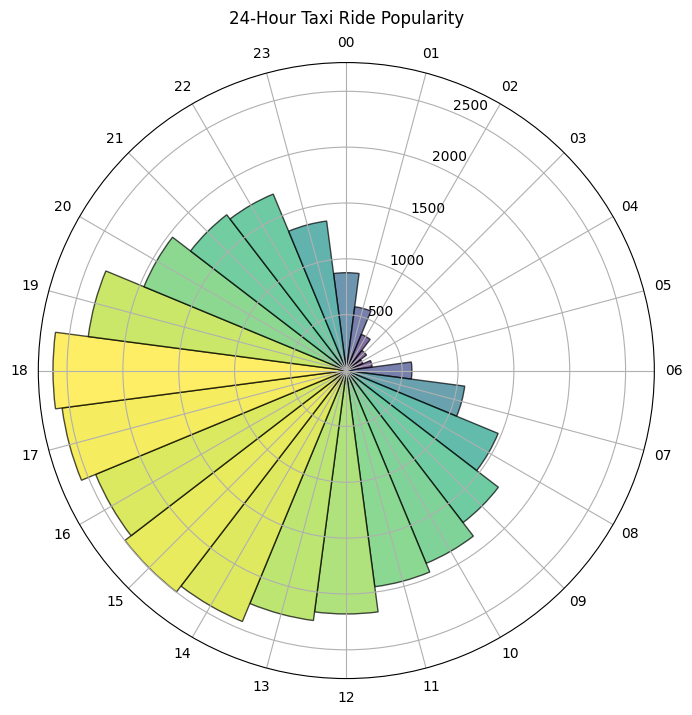

In [224]:
plot_by_hour_taxi_ride_cnt(get_data_for_by_hour_taxi_ride_cnt())

### Visualization 2

In [91]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def plot_by_month_hired_avg_distance(dataframe):
    groups = dataframe.groupby('month')['distance']
    raw = []
    for month,group in groups:
        distance = group
        mean = group.mean()
        std = np.std(distance,ddof=1)
        n = len(distance)

        margin = 1.645*std/np.sqrt(n)
        lower = mean - margin
        upper = mean + margin

        raw.append({'month':month,'mean':mean,'lower':lower,'upper':upper})
    df = pd.DataFrame(raw)

    fig,ax = plt.subplots(figsize=(10,6))
    line, = ax.plot([],[],label='Average Distance',marker = 'o',color='b')
    fill = ax.fill_between([],[],[],color='b',alpha=0.2,label='95% Confidence Interval')

    # ax.set_xlim(1,12)
    # ax.set_ylim(0,df['upper'].max()+1)
    ax.set_title('Monthly Taxi Trip Distance with Confidence Interval')
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Distance')
    ax.legend()
    ax.grid()

    def update(frame):
        cur = df.iloc[:frame+1]
        line.set_data(cur['month'],cur['mean'])
        global fill
        fill.remove()
        fill = ax.fill_between(cur['month'],cur['lower'],cur['upper'],color='b',alpha=0.2)
        return line,fill
    anim = FuncAnimation(fig,update,frames=len(df),interval=500,repeat=False)
    return HTML(anim.to_jshtml())

In [83]:
import pandas as pd
def get_data_for_by_month_hired_avg_distance():
    QUERY = """
            SELECT 
                strftime('%m',pickup_datetime) AS mon,
                trip_distance
            FROM 
                yellow_taxi_trips
            
        UNION ALL

            SELECT 
                strftime('%m',pickup_datetime) AS mon,
                trip_miles AS trip_distance
                
            FROM 
                uber_trips
            
        """
    with conn:
        results = conn.execute(QUERY).fetchall()
    return pd.DataFrame(results,columns=['month','distance']).sort_values(by='month')

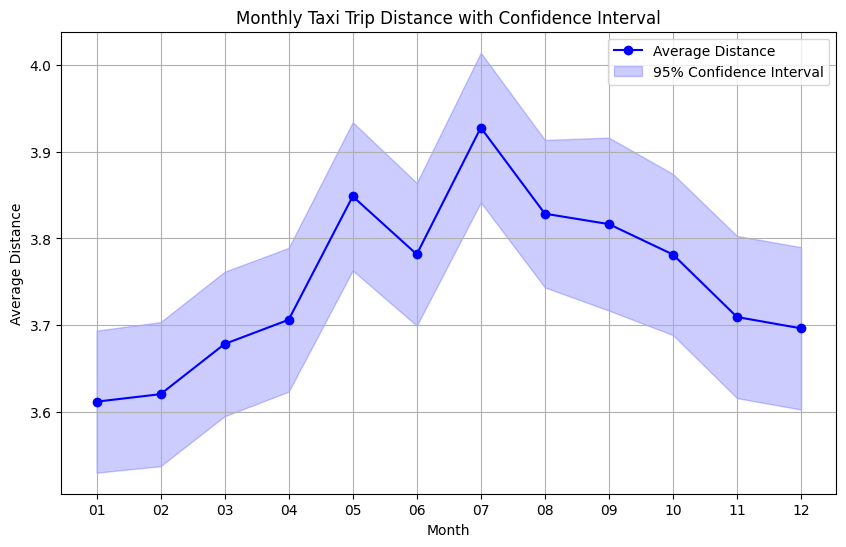

In [92]:
plot_by_month_hired_avg_distance(get_data_for_by_month_hired_avg_distance())

### Visualization 3

 Which day of the week is most popular for taking a ride to an NYC-based airport?
Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport between January 2020 and August 2024, inclusive. 


In [291]:
def plot_day_of_week_frequency_to_airport(dataframe:pd.DataFrame)->None:
    plt.figure(figsize=(10,6))

    x = dataframe['day_of_week'].astype(int)
    days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    plt.xticks(x,days)
    plt.bar(x,dataframe['ride_cnt'],label = 'Ride Count')
    plt.xlabel('Day of Week')
    plt.ylabel('Ride  count')
    plt.legend()
    plt.show()


In [292]:
def get_data_for_day_of_week_frequency_to_airport()->pd.DataFrame:
    QUERY = '''
    WITH total AS(
        SELECT 
            strftime('%Y-%m-%d',pickup_datetime) AS date,
            dropoff_latitude AS lat,
            dropoff_longitude AS lng
        FROM 
            yellow_taxi_trips
        WHERE
            (dropoff_latitude BETWEEN 40.766 AND 40.790 AND dropoff_longitude BETWEEN -73.890 AND -73.860)
            OR
            (dropoff_latitude BETWEEN 40.641 AND 40.662 AND dropoff_longitude BETWEEN -73.790 AND -73.750)
            OR
            (dropoff_latitude BETWEEN 40.689 AND 40.709 AND dropoff_longitude BETWEEN -74.190 AND -74.170)
        UNION ALL

        SELECT 
            strftime('%Y-%m-%d',pickup_datetime) AS date,
            dropoff_latitude AS lat,
            dropoff_longitude AS lng
        FROM 
            uber_trips
        WHERE
            (dropoff_latitude BETWEEN 40.76 AND 40.77 AND dropoff_longitude BETWEEN -73.88 AND -73.85)
            OR
            (dropoff_latitude BETWEEN 40.62 AND 40.66 AND dropoff_longitude BETWEEN -73.82 AND -73.74)
            OR
            (dropoff_latitude BETWEEN 40.67 AND 40.70 AND dropoff_longitude BETWEEN -74.19 AND -74.15)
        )
    SELECT
        strftime('%w',date) AS day_of_week,
        COUNT(*) AS ride_cnt
    FROM total
    GROUP BY strftime('%w',date)
'''
    with conn:
        results = conn.execute(QUERY).fetchall()
    return pd.DataFrame(results,columns=['day_of_week','ride_cnt'])

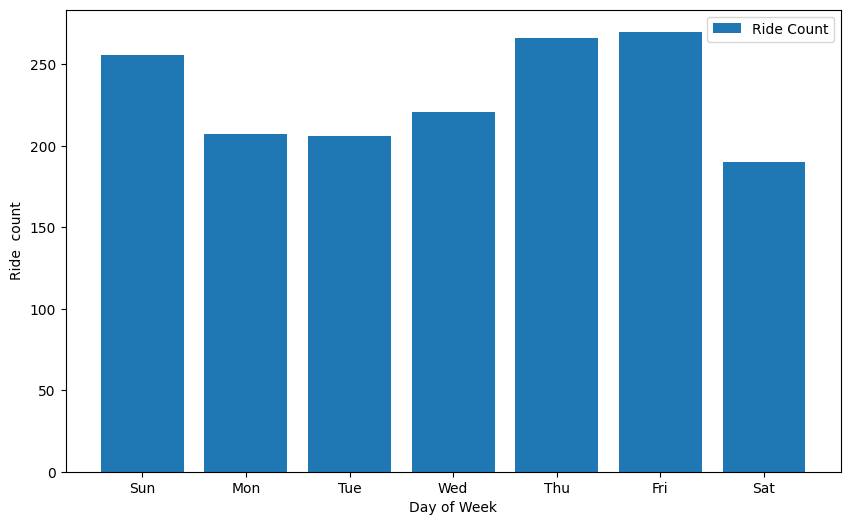

In [293]:
dataframe = get_data_for_day_of_week_frequency_to_airport()
plot_day_of_week_frequency_to_airport(dataframe)

people might start the travel at the end of the weekday(Thu,Fri),and people who travel to NY might go home at Sunday.

### Visualization 4

Visualization 4: How much do hired rides earn in total fares monthly?
Create an appropriate visualization that compares the monthly earned total fares between January 2020 through August 2024 (inclusive) for Yellow Taxis and Ubers each. Additionally, separate out fares, surcharges, taxes, and tolls.

Note: Total fare = base fare + all surcharges + taxes + tolls.


In [67]:
def plot_monthly_fare(dataframe:pd.DataFrame)->None:
    month = pd.to_datetime(dataframe['month']).apply(lambda x:x.strftime('%Y-%m'))
    uber = dataframe[['uber_base_fare','uber_all_surcharges','uber_taxes','uber_tolls','uber_total']]
    taxi = dataframe[['taxi_base_fare','taxi_all_surcharges','taxi_taxes','taxi_tolls','taxi_total']]
    components = ['total','base_fare','all_surcharges','taxes','tolls']
    x = np.arange(len(month))
    width = 0.3
    fig,ax = plt.subplots(5,1,figsize=(14,16))
    for i,component in enumerate(components):
        ax[i].bar(x-width/2,taxi[f'taxi_{component}'],width,label='taxi')
        ax[i].bar(x+width/2,uber[f'uber_{component}'],width,label='uber')

        ax[i].set_title(f'Monthly {component} comparation')
        ax[i].set_xlabel('Month')
        ax[i].set_ylabel(f'{component} Amount')

        tick_interval = 4
        xticks_indices = range(0,len(month),tick_interval)
        xtick_labels = month[xticks_indices]

        ax[i].set_xticks(xticks_indices)
        ax[i].set_xticklabels(xtick_labels)
        ax[i].legend()

    plt.tight_layout()
    plt.show()


In [48]:
def get_data_for_monthly_fare()->pd.DataFrame:
    QUERY = '''
    WITH uber AS(
    SELECT
        SUM(COALESCE(base_passenger_fare,0)) AS uber_base_fare,
        SUM(COALESCE(congestion_surcharge,0))+SUM(COALESCE(airport_fee,0))+SUM(COALESCE(Black_Car_Fund,0)) AS uber_all_surcharges,
        SUM(COALESCE(sales_tax,0)) AS uber_taxes,
        SUM(COALESCE(tolls,0)) as uber_tolls,
        strftime('%Y-%m',pickup_datetime) AS uber_month
    FROM uber_trips
    GROUP BY strftime('%Y-%m',pickup_datetime)),
    taxi AS(
    SELECT 
        SUM(COALESCE(fare_amount,0)) AS taxi_base_fare,
        SUM(COALESCE(Miscellaneous_Extras,0))+SUM(COALESCE(improvement_surcharge,0))+SUM(COALESCE(congestion_surcharge,0))+SUM(COALESCE(airport_fee,0)) AS taxi_all_surcharges,
        SUM(COALESCE(mta_tax,0)) AS taxi_taxes,
        SUM(COALESCE(tolls_amount,0)) AS taxi_tolls,
        strftime('%Y-%m',pickup_datetime) AS taxi_month
    FROM yellow_taxi_trips
    GROUP BY strftime('%Y-%m',pickup_datetime))
    SELECT
        uber_month,uber_base_fare,uber_all_surcharges,uber_taxes,uber_tolls,
        taxi_base_fare,taxi_all_surcharges,taxi_taxes,taxi_tolls,
        uber_base_fare+uber_all_surcharges+uber_taxes+uber_tolls AS uber_total,
        taxi_base_fare+taxi_all_surcharges+taxi_taxes+taxi_tolls AS taxi_total
    FROM uber
    JOIN taxi
    ON uber_month=taxi_month
'''
    with conn:
        results = conn.execute(QUERY).fetchall()
    return pd.DataFrame(results,columns=['month','uber_base_fare','uber_all_surcharges','uber_taxes','uber_tolls',
        'taxi_base_fare','taxi_all_surcharges','taxi_taxes','taxi_tolls','uber_total','taxi_total'])

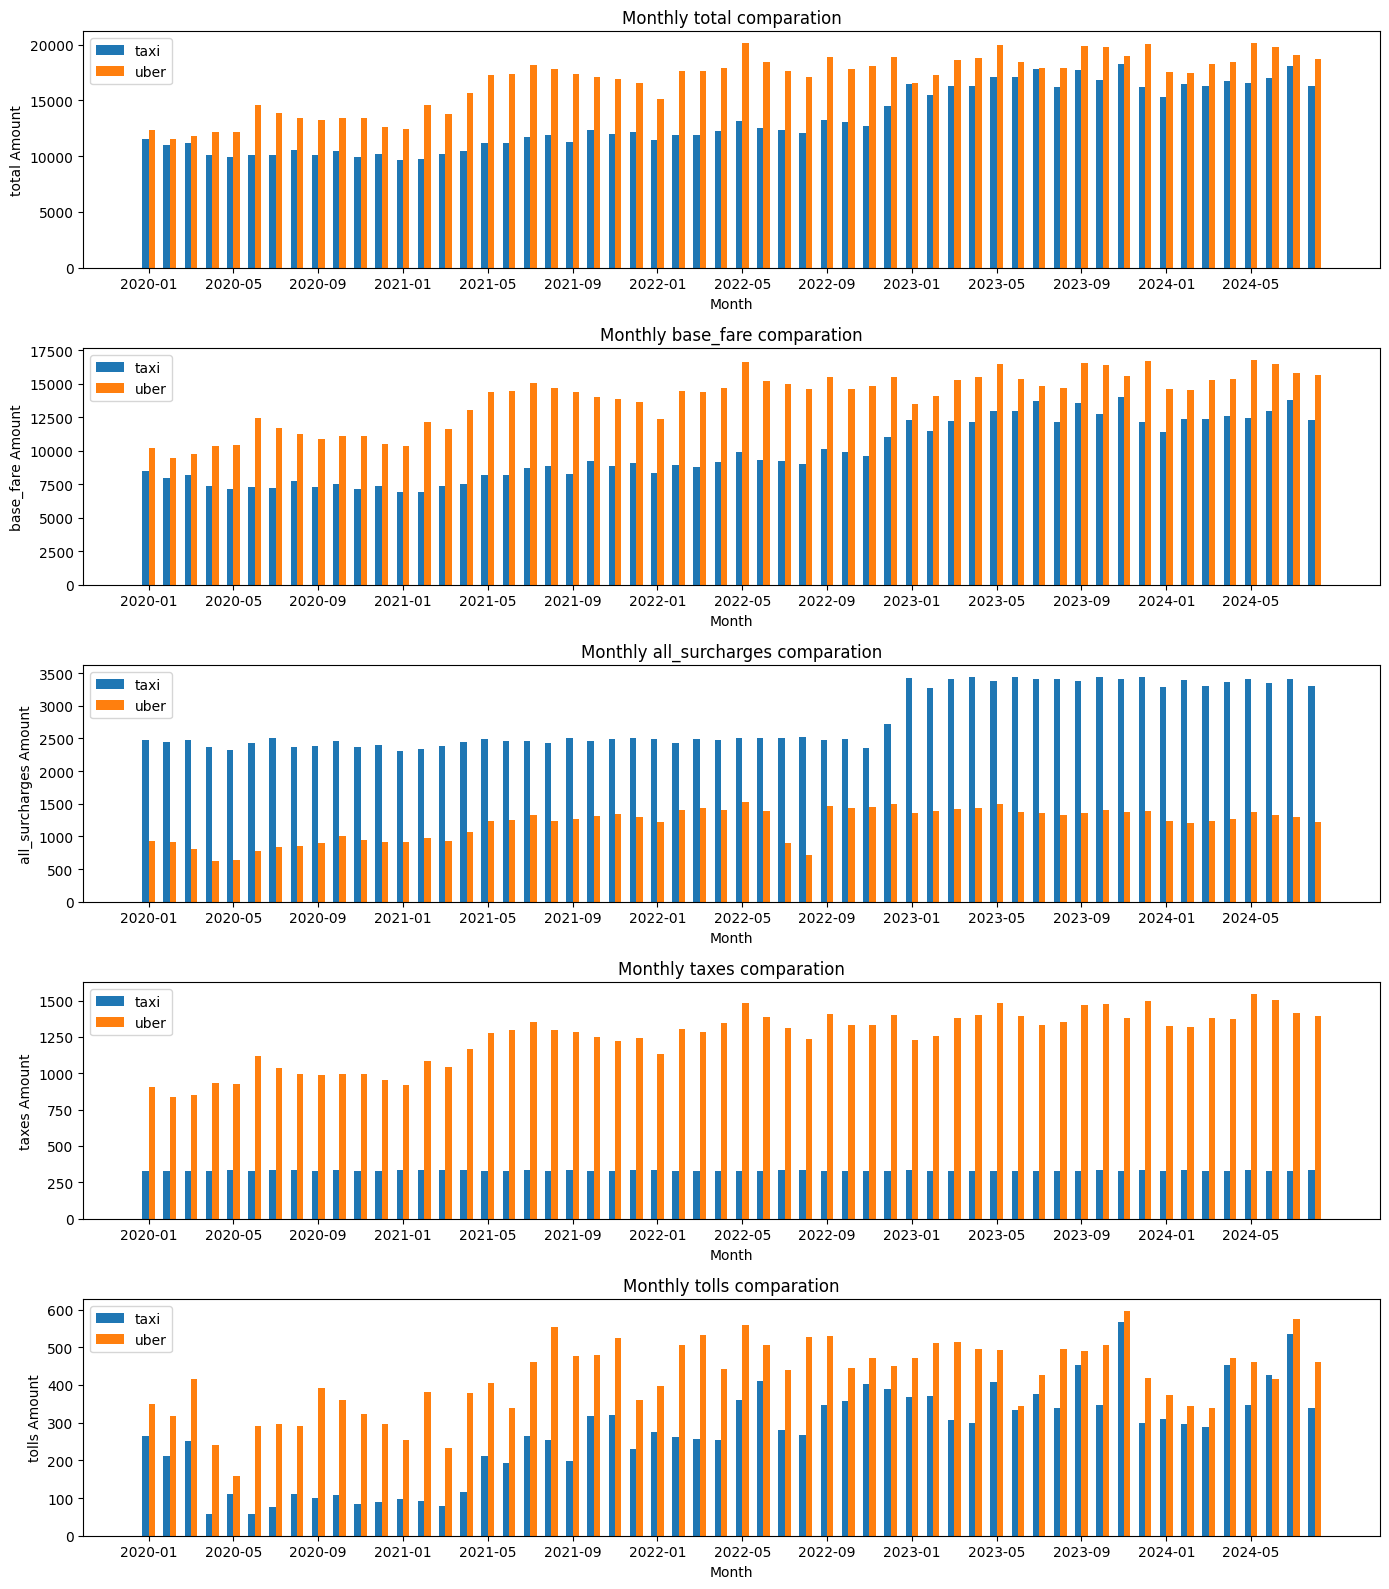

In [68]:
dataframe = get_data_for_monthly_fare()
plot_monthly_fare(dataframe)

### Visualization 5

Visualization 5: Does precipitation or distance traveled affect the amount of tip?
For the year 2022-2023, create 4 scatter plots, each one comparing amount of tip versus: 
distance for Yellow Taxi rides,
distance for Uber rides,
precipitation for Yellow Taxi rides, 
precipitation for Uber rides.

You may remove any outliers how you see fit.

If using matplotlib, then create a single figure with 2x2 subplots (example). If using another visualization library, try to accomplish something similar.


In [ ]:
def remove_outliers(df,col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    return df[(df[col]>=lower_bound)&(df[col]<=upper_bound)]

In [75]:
def plot_tip_factors(uber,taxi,weather)->None:
    uber = uber[uber['tips']<=50]
    taxi = taxi[taxi['tips']<=50]
    uber_weather = pd.merge(uber,weather,on='hour',how='left')
    taxi_weather = pd.merge(taxi,weather,on='hour',how='left')
    uber_weather_distance = remove_outliers(uber_weather,'distance')
    taxi_weather_distance = remove_outliers(taxi_weather,'distance')

    fig,ax = plt.subplots(2,2,figsize=(12,10))
    ax[0,0].scatter(taxi_weather_distance['distance'],taxi_weather_distance['tips'],alpha=0.1)
    ax[0,0].set_title('taxi: distance VS tips')
    ax[0,0].set_xlabel('distance')
    ax[0,0].set_ylabel('tips')

    ax[0,1].scatter(uber_weather_distance['distance'],uber_weather_distance['tips'],alpha=0.1)
    ax[0,1].set_title('uber: distance VS tips')
    ax[0,1].set_xlabel('distance')
    ax[0,1].set_ylabel('tips')

    ax[1,0].scatter(taxi_weather['HourlyPrecipitation'],taxi_weather['tips'],alpha=0.1)
    ax[1,0].set_title('taxi: precipitation VS tips')
    ax[1,0].set_xlabel('precipitation')
    ax[1,0].set_ylabel('tips')

    ax[1,1].scatter(uber_weather['HourlyPrecipitation'],uber_weather['tips'],alpha=0.1)
    ax[1,1].set_title('uber: precipitation VS tips')
    ax[1,1].set_xlabel('precipitation')
    ax[1,1].set_ylabel('tips')
    
        

In [17]:
def get_data_for_tip_factors():
    UBER_QUERY = '''
    SELECT
        strftime('%Y-%m-%d %H',pickup_datetime) AS hour_time,
        tips,
        trip_miles
    FROM uber_trips
    WHERE strftime('%Y',pickup_datetime) BETWEEN '2022' AND '2023'
    '''
    TAXI_QUERY = '''
    SELECT
        strftime('%Y-%m-%d %H',pickup_datetime) AS hour_time,
        tip_amount,
        trip_distance
    FROM yellow_taxi_trips
    WHERE strftime('%Y',pickup_datetime) BETWEEN '2022' AND '2023'
'''
    WEATHER_QUERY = '''
    SELECT 
        strftime('%Y-%m-%d %H',CAST(Date AS TEXT) || ' ' || printf('%02d', Hour)||':00:00') AS hour_time,
        HourlyPrecipitation
    FROM weather_hourly
    WHERE strftime('%Y',Date) BETWEEN '2022' AND '2023'
'''
    with conn:
        uber = conn.execute(UBER_QUERY).fetchall()
        taxi = conn.execute(TAXI_QUERY).fetchall()
        weather = conn.execute(WEATHER_QUERY).fetchall()
    return  [pd.DataFrame(uber,columns=['hour','tips','distance']),pd.DataFrame(taxi,columns=['hour','tips','distance']),pd.DataFrame(weather,columns=['hour','HourlyPrecipitation'])]

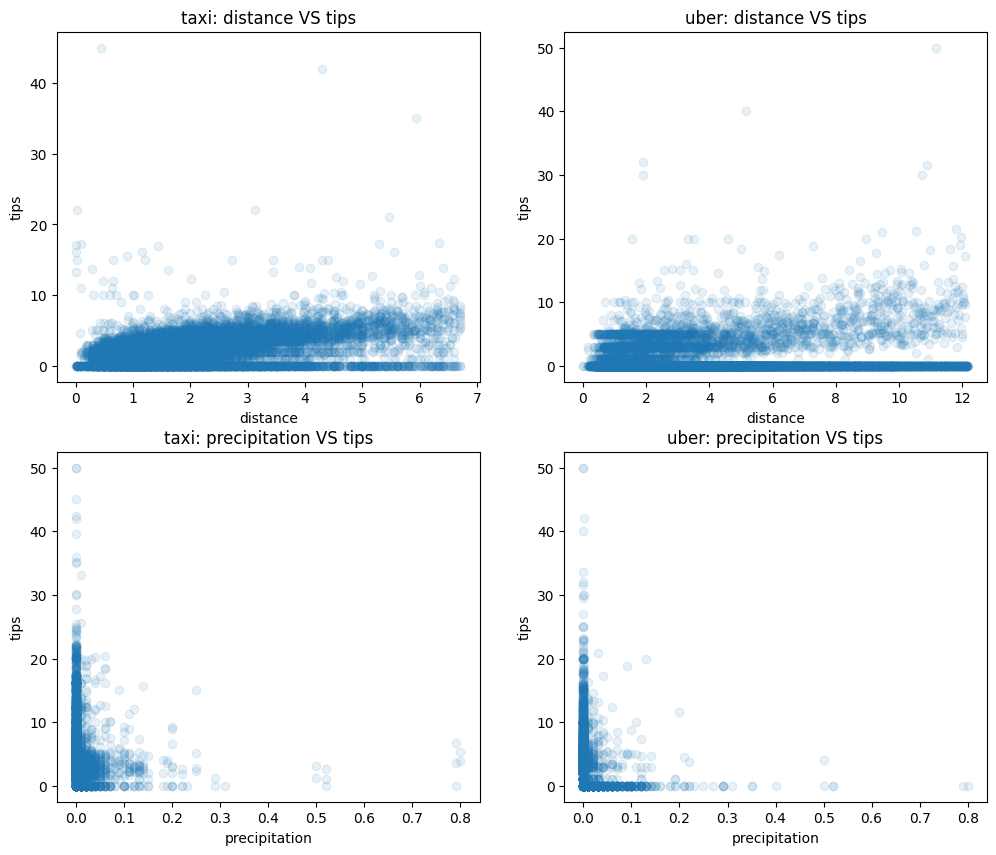

In [76]:
uber,taxi,weather = get_data_for_tip_factors()
plot_tip_factors(uber,taxi,weather)

### Visualization 6

Create a heatmap of all hired trips in 2020 over a map of the area. Consider using Folium, geopandas, KeplerGL, geoplot, or another library that helps generate geospatial visualizations.

Depending on the library you use, the visualization may not render when viewing on GitHub (after you’ve pushed your code). If that’s the case, please include a screenshot in your repository.


In [79]:
def plot_heatmap(dataframe:pd.DataFrame)->None:
    pick_counts = dataframe.groupby(['pick_lat','pick_lng']).size().reset_index(name='counts')
    pick_data = pick_counts[['pick_lat','pick_lng','counts']].values
    drop_counts = dataframe.groupby(['drop_lat','drop_lng']).size().reset_index(name='counts')
    drop_data = drop_counts[['drop_lat','drop_lng','counts']].values
    from folium.plugins import HeatMap
    import folium
    pick_m = folium.Map(location=[dataframe['pick_lat'].mean(),dataframe['pick_lng'].mean()],zomm_start=12)
    drop_m = folium.Map(location = [dataframe['drop_lat'].mean(),dataframe['drop_lng'].mean()],zoom_start=12)

    HeatMap(pick_data,radius=15,blur=10,min_opacity=0.2).add_to(pick_m)
    HeatMap(drop_data,radius=15,blur=10,min_opacity=0.2).add_to(drop_m)
    display(pick_m)
    display(drop_m)

In [60]:
def get_data_for_heatmap():
    QUERY = '''
    SELECT
        pickup_latitude AS pick_lat,
        pickup_longitude AS pick_lng,
        dropoff_latitude AS drop_lat,
        dropoff_longitude AS drop_lng
    FROM uber_trips
    WHERE strftime('%Y',pickup_datetime)='2020'
    UNION
    SELECT
        pickup_latitude AS pick_lat,
        pickup_longitude AS pick_lng,
        dropoff_latitude AS drop_lat,
        dropoff_longitude AS drop_lng
    FROM yellow_taxi_trips
    WHERE strftime('%Y',pickup_datetime)='2020'
    '''
    with conn:
        results = conn.execute(QUERY).fetchall()
    return pd.DataFrame(results,columns=['pick_lat','pick_lng','drop_lat','drop_lng'])

In [80]:
dataframe = get_data_for_heatmap()
plot_heatmap(dataframe)